# Piece-wise linear potential 4 - importance sampling

This is the fourth, and final, in a series of notebooks which will run importance sampling for the piece-wise linear potential. Familiarity with importance sampling is assumed

In this notebook we show how to run stochastic simulations and compare the different noise models.

We start as we did before by defining everything we need and loading in the required data

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

# Need to make sure you have pyfpt installed
import pyfpt as fpt
import multiprocessing as mp
from multiprocessing import Process, Queue
from timeit import default_timer as timer

from scipy.optimize import root
from scipy.integrate import quad
from scipy.integrate import trapezoid
from scipy.interpolate import CubicSpline

# Let us define the different colours used
color = ['#377eb8', '#ff7f00', '#984ea3','#4daf4a', '#a65628', '#f781bf','#999999', '#e41a1c', '#dede00']

## The potential

In [2]:
def potential(phi):
    if phi > phi_star:
        return V_0 + A_plus*(phi - phi_star)
    elif phi <= phi_star:
        return V_0 + A_minus*(phi - phi_star)

    
def potential_dif(phi):
    if phi > phi_star:
        return A_plus
    elif phi <= phi_star:
        return A_minus

def potential_ddif(phi):
    return 0.

def V_prime_by_V(phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$.

In [3]:
pi_num = np.pi

A_plus = 10**-14
A_minus = A_plus*(10**-3)
cmb_power_spectrum = 2*10**-9
V_0 = (12*cmb_power_spectrum*(pi_num*A_plus)**2)**(1/3)
H_0 = (V_0/3)**(1/2)
N_star = 26.
phi_star = 1.

## Loading in background
We have already simulated the background, now we can just load it in.

In [4]:
background_data = pd.read_csv("piece_wise_linear_dynamics_dynamics"+".csv", index_col=0)

N_values = np.array(background_data["N"])
phi_values = np.array(background_data["phi"])
phi_diff_values = np.array(background_data["phi_N_diff"])
hubble_param_values = np.array(background_data["H"])
epsilon1_values = np.array(background_data["epsilon1"])
epsilon2_values = np.array(background_data["epsilon2"])
nu_squared_values = np.array(background_data["nu_squared"])

N_end = N_values[-1]
phi_end_true = phi_values[-1]
a_in = 1

In [5]:
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))

phi_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_values)
phi_diff_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_diff_values)

Updating the interpolation which are senstive to any errors to use the analytical versions.

In [6]:
def comoving_time_func(N_interest, N_end):
    def comoving_time_integrand(N):
        aH = aH_interpolation(N)
        return 1/aH
    comoving_time_value, _ = quad(comoving_time_integrand, N_end, N_interest, limit=1000)
    return comoving_time_value

def analytical_epsilon_1(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_1 = (A_plus**2)/(18*(H**4))
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_1 = ((Delta_A*(comoving_time*k_transition)**3 + A_minus)**2)/(18*(H**4))
    return epsilon_1

def analytical_epsilon_2(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_2 = 0.
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_2 =\
            (-6*Delta_A*(comoving_time*k_transition)**3)/(Delta_A*(comoving_time*k_transition)**3 + A_minus)
    return epsilon_2

In [7]:
epsilon1_values = np.array([analytical_epsilon_1(N_values[i], N_end, N_star, A_plus, A_minus) for i in range(len(N_values))])
epsilon2_values = np.array([analytical_epsilon_2(N_values[i], N_end, N_star, A_plus, A_minus) for i in range(len(N_values))])

# interpolation
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)

In [8]:
def nu_sqaured_func(N):
    epsilon2 = epsilon2_interpolation(N, 0)
    epsilon1 = epsilon1_interpolation(N, 0)
    epsilon2_derivative = epsilon2_interpolation(N, 1)
    return 9/4 - epsilon1 + (3/2)*epsilon2 - (1/2)*epsilon1*epsilon2 + (epsilon2**2)/4\
        + epsilon2_derivative/2

In [9]:
nu_squared_values = np.array([nu_sqaured_func(N_values[i]) for i in range(len(N_values))])

nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

In [10]:
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_star))

N_sim_end_estimate = N_star + np.log(10**3)

sim_range_logic = (N_values>N_star+0.05) & (N_values<N_sim_end_estimate)

N_values_sim_range = N_values[sim_range_logic]
phi_values_sim_range = phi_values[sim_range_logic]
phi_diff_values_sim_range = phi_diff_values[sim_range_logic]


N_sim_start = N_values_sim_range[0]
phi_sim_start = phi_values_sim_range[0]
phi_sim_diff_start = phi_diff_values_sim_range[0]

N_sim_end = N_values_sim_range[-1]
phi_sim_end = phi_values_sim_range[-1]
phi_sim_diff_end = phi_diff_values_sim_range[-1]

Some values and functions we need.

In [11]:
dN = 0.00038251633703158353

analytical_fpt_std = 0.12190137996950524

In [12]:
def find_cg_time(k, sigma, N_exit):
    def exit_time_func(N_cg_exit):
        return k - sigma*aH_interpolation(N_cg_exit)
    N_guess = N_exit + np.log(sigma**-1)
    sol_cg_time = root(exit_time_func, N_guess)
    N_cg_exit = sol_cg_time.x
    return float(N_cg_exit)

In [13]:
def analytical_delta_phi(N_interest, N_end, N_transition, A_plus, A_minus, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    H0 = hubble_param_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.

    term1 = complex(1, k_eta)*np.exp(complex(0, -k_eta))
    term2 = complex(1, -k_eta)*np.exp(complex(0, k_eta))
    k_term = complex(0, H0/(2*k**3)**0.5)

    delta_phi = k_term*(alpha*term1 - beta*term2)
    return delta_phi

In [14]:
def power_spectrum_func(k, R):
    return (np.abs(R)**2)*(k**3)/(2*np.pi**2)

# Importance sampling

Here we run simulations using importance sampling to investigate the far tail. As it is more straightforward to implement the 1D noise, that is what we do here. 

In [15]:
%load_ext cython

In [16]:
%%cython -a

import numpy as np

cdef double e = 2.718281828459045
cdef double pi_const = 3.141592653589793
cdef double phi_star = 1.0
cdef double A_plus = 1e-14
cdef double A_minus = 1e-17
cdef double V_0 = 2.871906714642027e-12
cdef double diff_const = 1.5572025557368665e-07
cdef double phi_old


cdef double V_prime_by_V_cython(double phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))
    
cdef int end_cond(double phi, double pi, double N, double phi_end):
    if phi<phi_end:
        return 1
    else:
        return 0


cdef list update(double phi, double pi, double A, double N, double dN, double [:] dW, double [:] noise,
                 double bias_amp):
    # Store old phi value to be used in calculating velocity
    phi_old = phi
    # Update field position
    # If noise is zero, no bias is automatically applied
    phi = phi + (pi + bias_amp*noise[0])*dN + noise[0]*dW[0]

    # Update the velocity
    if noise[0]>0:  #Need to include the chance the noise is zero
        pi =\
            pi - (3 - 0.5*pi**2)*(pi + V_prime_by_V_cython(phi_old))*dN +\
             bias_amp*noise[1]*dN + noise[1]*dW[0]

        # Use the standard form for the weight calculation
        A += bias_amp*(0.5*bias_amp*dN + dW[0])
    else:
        pi =\
            pi - (3 - 0.5*pi**2)*(pi + V_prime_by_V_cython(phi_old))*dN
        # No change as no noise is applied.
        A += 0.

    return [phi, pi, A]


#A let's us calculate the bias w=e^-A is the bias, which propagated along with 
#the importance sample path.
#See Eq. (33) of arXiv:nucl-th/9809075v1 for more info
cdef list simulation_diff_general_end(double x_in, double y_in, double t_in,\
                          double t_f, double dt, double bias_amp, double phi_end_in, noise_list, rng):
    cdef double t, sqrt_dt, x, y, z, A
    cdef int i = 0
    cdef int end_cond_value
    cdef int len_rand_nums = 1000
    cdef int reduced_step = 0
    cdef int num_steps = 0
    
    cdef double [:, :] rand_nums
    cdef double [:] dW
    cdef double [:] noise

    t = t_in
    x = x_in
    y = y_in
    sqrt_dt = dt**0.5
    A = 0.0
    rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
    dW = rand_nums[:, 0]
    noise = noise_list[:, 0]

    while t<t_f:
        # Scale the step varaince to the dt used
        dW[0] = sqrt_dt*rand_nums[0, i]
        dW[1] = sqrt_dt*rand_nums[1, i]
        # Find the noise from the list provided
        noise[0] = noise_list[0, num_steps]
        noise[1] = noise_list[1, num_steps]
        # Define the Wiener step, using the pre-drawn random numbers.
        # Step in x and A simultanioues
        [x, y, A] =\
            update(x, y, A, t, dt, dW, noise, bias_amp)
        t += dt
        i += 1
        num_steps += 1
        # Using 1/0 for True/False
        end_cond_value = end_cond(x, y, t, phi_end_in)
        if end_cond_value == 1:
            break
        elif end_cond_value == -1 and reduced_step == 0:
            dt = dt/100
            sqrt_dt = dt**0.5
            reduced_step = 1
        elif end_cond_value == 0 and reduced_step == 1:
            dt = 100*dt
            sqrt_dt = dt**0.5
            reduced_step = 0
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
            i = 0
    return [t, e**(-A)]


cpdef importance_sampling_simulations_2dim_1d_noise(double x_in, double y_in, double t_in, double t_f,
                                           double dt, int num_runs, double bias_amp, double phi_end_in,
                                                noise_list):
    # As this variable is global, I can just redfine it hear
    rng = np.random.default_rng()
    results =\
        [simulation_diff_general_end(x_in, y_in, t_in, t_f, dt, bias_amp, phi_end_in, noise_list, rng)\
         for i in range(num_runs)]
                
    
    ts, ws = [[results[i][j] for i in range(num_runs)] for j in range(2)]
    return ts, ws

In [17]:
def run_func_full_1D(N_exit, N_start, bias_amp, num_runs, noise_matrix, sigma, phi_in_post,
                                phi_deriv_in_post, phi_end, extra_label=None):

    start = timer()
    num_runs_per_core = int(num_runs/mp.cpu_count())

    # Using multiprocessing
    def multi_processing_func(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end, noise_matrix, queue_efolds,
                              queue_ws):
        results =\
            importance_sampling_simulations_2dim_1d_noise(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end,
                                                      noise_matrix)
        fpt_values = np.array(results[0][:])
        ws = np.array(results[1][:])
        queue_efolds.put(fpt_values)
        queue_ws.put(ws)
    queue_efolds = Queue()
    queue_ws = Queue()
    cores = int(mp.cpu_count()/1)

    print('Number of cores used: '+str(cores))
    processes = [Process(target=multi_processing_func,
                         args=(phi_in_post, phi_deriv_in_post, N_start, 80., dN, num_runs_per_core, bias_amp,
                               phi_end, noise_matrix, queue_efolds, queue_ws))
                 for k in range(cores)]

    for p in processes:
        p.start()

    # More efficient to work with numpy arrays
    fpt_array = np.array([queue_efolds.get() for p in processes])
    ws_array = np.array([queue_ws.get() for p in processes])

    end = timer()
    print(f'The simulations took: {end - start} seconds')

    # Combine into columns into 1
    fpt_values = fpt_array.flatten()
    w_values = ws_array.flatten()

    # Sort in order of increasing Ns
    sort_idx = np.argsort(fpt_values)
    Ns = fpt_values[sort_idx]
    ws = w_values[sort_idx]
    if extra_label != None:
        extra_label = "_sigma_"+str(sigma)+"_A_log_ration_"\
                                           +str(np.log10(A_minus/A_plus))+"scale_exited"+str(round(N_exit, 5))\
                                            + "_1D_" + extra_label
    else:
        extra_label = "_sigma_"+str(sigma)+"_A_log_ration_"\
                                           +str(np.log10(A_minus/A_plus))+"scale_exited"+str(round(N_exit, 5))\
                                            + "_1D"

    fpt.numerics.save_data_to_file(Ns, ws, round(phi_in_post, 5), num_runs, bias_amp,
                      extra_label=extra_label)

To run the importance sampling simulations, all we have to do is add a bias to the simulations we run previously.

We will only consider $\sigma=1$ here, as we are simply interested in if importance sampling is self-consistent.

Note that as we already an direct sampling in the last notebook, we don't need to simulate a bias amplitude of 0 here.

In [18]:
sigma = 1.0

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))
# Interpolation over the phase spcae such that the position/velocity at any scale can be found
phi_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_values)
phi_diff_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_diff_values)

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

# Scales at the start and end
k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# This returns an array, so need to convert to a float
phi_in = float(phi_with_scale_interpolation(k_in_scale/sigma))
phi_deriv_in = float(phi_diff_with_scale_interpolation(k_in_scale/sigma))

# end value
N_sim_end_later = N_sim_end+2
k_end_scale_later = aH_interpolation(N_sim_end_later)
N_sim_end_later_sigma_exit = find_cg_time(aH_interpolation(N_sim_end_later), sigma, N_sim_end_later)
phi_end = float(phi_with_scale_interpolation(k_end_scale_later/sigma))

In [19]:
num_runs = 10**5

sigma = 1.0

# load in the noise curve
noise_data = pd.read_csv("piece_wise_linear_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_1D.csv",
                             index_col=0)

N_cg_values = np.array(noise_data["N"])

noise_matrix_array = np.zeros((2, len(N_cg_values)))

noise_matrix_array[0, :] = np.array(noise_data["phi-phi noise"])
noise_matrix_array[1, :] = np.array(noise_data["pi-pi noise"])

# Need to add the zeros such there is enough noise to reach the end of the simulation
noise_matrix_array_with_zeros = np.zeros((2, len(noise_matrix_array[0,:])+int(4/dN)))

noise_matrix_array_with_zeros[:, :len(noise_matrix_array[0,:])] = noise_matrix_array
# Now need to find the correct start position and end value

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

# Scales at the start and end
k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# This returns an array, so need to convert to a float
phi_in = float(phi_with_scale_interpolation(k_in_scale/sigma))
phi_deriv_in = float(phi_diff_with_scale_interpolation(k_in_scale/sigma))

# end value
k_end_scale_later = aH_interpolation(N_sim_end_later)
N_sim_end_later_sigma_exit = find_cg_time(aH_interpolation(N_sim_end_later), sigma, N_sim_end_later)
phi_end = float(phi_with_scale_interpolation(k_end_scale_later/sigma))

bias_amp_values = [1., 2., 3.]

for bias_amp in bias_amp_values:
    run_func_full_1D(N_sim_start, N_start_sigma_exit, bias_amp, num_runs, noise_matrix_array_with_zeros, sigma,
                                  phi_in, phi_deriv_in, phi_end, extra_label="bessel")

Number of cores used: 8
The simulations took: 228.5255305269966 seconds
Saved data to file IS_data_x_in_1.0_iterations_100000_bias_1.0_sigma_1.0_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv
Number of cores used: 8
The simulations took: 243.4191173320869 seconds
Saved data to file IS_data_x_in_1.0_iterations_100000_bias_2.0_sigma_1.0_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv
Number of cores used: 8
The simulations took: 248.84428949805442 seconds
Saved data to file IS_data_x_in_1.0_iterations_100000_bias_3.0_sigma_1.0_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv


We also want to compare against the Gaussian prediction.

In [20]:
def gaussian_pdf_generator(std, mean=0):
    def pdf(x):
        expo_term = np.exp(-0.5*((x-mean)/std)**2)
        norm = 1/(std*(2*np.pi)**0.5)
        return norm*expo_term
    return pdf

Now we can compare the two choices of $\sigma$, as well as the Gaussian and classical $\delta \mathcal{N}$ predictions.

In [21]:
classical_pdf = gaussian_pdf_generator(analytical_fpt_std, mean=0.0)

Possibly not lognormal distribution. Smallest p-value is:
0.0027325346750240445
Possibly not lognormal distribution. Smallest p-value is:
0.0047987151796340865


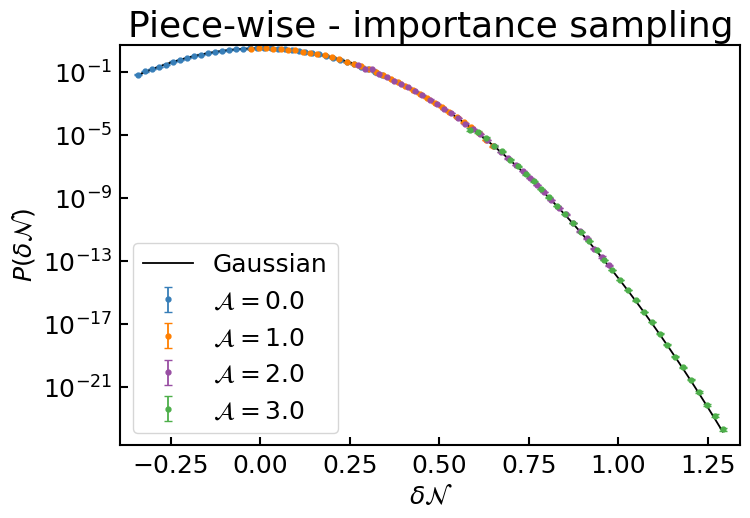

<Figure size 800x520 with 0 Axes>

In [22]:
sigma = 1.
bias_amp_values = [0., 1., 2., 3.]

for i in range(len(bias_amp_values)):
    # Very important to keep everything as Python objects
    bias_amp = float(bias_amp_values[i])
    base_file_name = "IS_data_x_in_1.0_iterations_100000_bias_"+str(bias_amp)+\
        "_sigma_"+str(1.0)+"_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv"
    raw_data = pd.read_csv(base_file_name, index_col=0)

    # Easier to work with NumPy arrays
    Ns = np.array(raw_data['FPTs'])
    ws = np.array(raw_data['ws'])

    if bias_amp==0.:
        bin_centres, heights, errors = fpt.numerics.re_processing(Ns, estimator="naive",
                                                                  min_bin_size=100, t_f=75)
    else:
        bin_centres, heights, errors = fpt.numerics.re_processing(Ns, weights=ws, estimator="lognormal",
                                                                  min_bin_size=100, t_f=75, display=False)

    bin_centres = np.array(bin_centres) - find_cg_time(k_end_scale_later, sigma, N_sim_end_later)

    if i == 0:
        bin_centres_combined = bin_centres
        bin_centres_combined = np.array(bin_centres_combined)
        heights_combined = heights
        heights_combined = np.array(heights_combined)
        errors_combined = errors
        errors_combined = np.array(errors_combined)
    else:
        bin_centres_combined = np.concatenate((bin_centres_combined, bin_centres))
        heights_combined = np.concatenate((heights_combined, heights))
        errors_combined = np.concatenate((errors_combined, errors), axis=1)

    plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7, label="$\mathcal{A}=$"+str(bias_amp),
                color=color[i])

sort_logic = np.argsort(bin_centres_combined)
bin_centres_combined = bin_centres_combined[sort_logic]
plt.plot(bin_centres_combined, classical_pdf(bin_centres_combined), color="k", label="Gaussian")
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.legend(fontsize=18)
plt.xlabel(r'$\delta \mathcal{N}$')
plt.ylabel(r'$P(\delta \mathcal{N})$')
plt.ylim(bottom = 0.1*np.min(heights_combined), top = 1.6*np.max(heights_combined))
plt.title(r"Piece-wise - importance sampling")
plt.xlim(left = np.min(bin_centres_combined)-0.05, right=np.max(bin_centres_combined)+0.05)
plt.show()
plt.clf()

Clearly the data is both self-consistent and in agreement with Gaussian prediction!

Note the lognormal estimator has detected some possible problems, but they are relatively large $p$-values. Only if $p < 10^{-5}$ should you really be concerned.